In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

Instructions for updating:
Use the retry module or similar alternatives.


# Task 1

Implement the RBM that uses CD-1 for training. For input data use MNIST numbers. The visible layer must then have 784 elements, and the hidden layer should have 100 elements. Since the values of the input samples (image) are real numbers in the range [0 1], they can be used as $p(v_i=1)$, so for the initial values of the visible layer, sampling should be performed. Set the mini batch size to 100 samples, and the number of epochs to 100.

Subtasks:

1. Visualize the weights of $W$ obtained by training and try to interpret the weights associated with some hidden neurons.
2. Visualize the reconstruction results of the first 20 MNIST samples. Visualize the values of $p(v_i=1)=σ(∑^N_{j=1} w_{ji}h_j+a_i)$ instead of the binary values obtained by sampling.
3. Examine the activation frequency of hidden layer elements and visualize the learned weights of $W$ sorted by the frequency
4. Skip the initial sampling/binarization based on the real input data, and use the original input data (real numbers from the range [0 1]) as input layer $v$. How different is such RBM from the previous one?
5. Increase the number of Gibs sampling in CDs. What are the differences?
6. Examine the effects of varying the learning constant.
7. Randomly initialize the hidden layer, run a few Gibbs samplings, and visualize the generated visible layer
8. Perform above experiments with a smaller and a larger number of hidden neurons. What do you observe about weights and reconstructions?

Use the following template with the utility file [utils.py](https://dlunizg.github.io/assets/lab4/utils.py).

REMARK: In addition to filling out the missing code, the template should be tailored as needed, and can be customized freely. So please be especially careful with the claims that some of the code is not working for you!

In [ ]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

In [64]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)


def sample_prob(probs):
    """Sample vector x by probability vector p (x = 1) = probs"""
    return tf.to_float(tf.random_uniform(tf.shape(probs)) <= probs)


def draw_weights(W, shape, N, stat_shape, title=None, interpolation="bilinear"):
    """Visualization of weight
     W - weight vector
     shape - tuple dimensions for 2D weight display - usually input image dimensions, eg (28,28)
     N - number weight vectors
     shape_state - Dimension for 2D state display (eg for 100 states (10,10)
    """
    image = (tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/stat_shape[0])), stat_shape[0]),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    if title:
        plt.title(title)
    plt.axis('off')
    
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, N):
    """Visualization of inputs and associated reconstructions and hidden layer states
     ins -- input vectors
     outs - reconstructed vectors
     states - hidden layer state vectors
     shape_in - dimension of input images eg (28,28)
     shape_state - Dimension for 2D state display (eg for 100 states (10,10)
     N - number of samples
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):
        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(states[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
        plt.axis('off')
    plt.tight_layout()

    
def draw_generated(stin, stout, gen, shape_gen, shape_state, N):
    """Visualization of initial hidden states, final hidden states and associated reconstructions
     stin - the initial hidden layer
     stout - reconstructed vectors
     gen - vector of hidden layer state
     shape_gen - dimensional input image eg (28,28)
     shape_state - Dimension for 2D state display (eg for 100 states (10,10)
     N - number of samples
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):

        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(stin[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("set state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(stout[i][0:784].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("final state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(gen[i].reshape(shape_gen), vmin=0, vmax=1, interpolation="nearest")
        plt.title("generated visible")
        plt.axis('off')
    plt.tight_layout()

    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def draw_rec(inp, title, size, Nrows, in_a_row, j):
    """ Draw an iteration of creating the visible layer
     inp - visible layer
     title - thumbnail title
     size - 2D dimensions of visible layer
     Nrows - max. number of thumbnail rows 
     in-a-row. number of thumbnails in one row
     j - position of thumbnails in the grid
    """
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases):
    """ Sequential visualization of  the visible layer reconstruction
     ind - index of digits in orig (matrix with digits as lines)
     states - state vectors of input vectors
     orig - original input vectors
     weights - weight matrix
    """
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(Nh):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()
    

In [3]:
def get_w1_grad(v, h):    
    v = tf.reshape(v, [-1, int(v.shape[1]), 1])
    h = tf.reshape(h, [-1, 1, int(h.shape[1])])
    return tf.reduce_sum(tf.matmul(v, h), reduction_indices=0) 

In [43]:

class Task1():
    def __init__(self, Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha, rnd_hidden_init=False):
        self.g1 = tf.Graph()
        with self.g1.as_default():

            self.X1 = tf.placeholder("float", [None, 784])
            self.w1 = weights([Nv, Nh])
            self.vb1 = bias([Nv]) # a_i - bias for visible layer
            self.hb1 = bias([Nh]) # b_i - bias for hidden layer

            self.h0_prob = tf.sigmoid(tf.matmul(self.X1, self.w1) + tf.transpose(self.hb1))
            if rnd_hidden_init:
                self.h0 = tf.to_float(tf.random_uniform(tf.shape(self.h0_prob)))
            else:
                self.h0 = sample_prob(self.h0_prob)
            self.h1 = self.h0

            for step in range(gibbs_sampling_steps):
                self.v1_prob = tf.sigmoid(tf.matmul(self.h1, tf.transpose(self.w1)) + tf.transpose(self.vb1))
                self.v1 = sample_prob(self.v1_prob)
                self.h1_prob = tf.sigmoid(tf.matmul(self.v1, self.w1) + tf.transpose(self.hb1))
                self.h1 = sample_prob(self.h1_prob)


            w1_positive_grad = get_w1_grad(self.X1, self.h0_prob)
            w1_negative_grad = get_w1_grad(self.v1_prob, self.h1_prob)

            dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(self.X1)[0]) # .shape[0] - number of rows

            update_w1 = tf.assign_add(self.w1, alpha * dw1)
            update_vb1 = tf.assign_add(self.vb1, alpha * tf.reduce_mean(self.X1 - self.v1, 0))
            update_hb1 = tf.assign_add(self.hb1, alpha * tf.reduce_mean(self.h0 - self.h1, 0)) 

            self.out1 = (update_w1, update_vb1, update_hb1)

            #v1_prob = # calculated before, in the loop
            #v1 = # not used anywhere later

            err1 = self.X1 - self.v1_prob
            self.err_sum1 = tf.reduce_mean(err1 * err1)

            initialize1 = tf.global_variables_initializer()
    
    
            self.sess1 = tf.Session(graph=self.g1)
            self.sess1.run(initialize1)
        
    def train(self, total_batch):
        print('training, total batch:', total_batch)
        for i in range(total_batch):
            batch, label = mnist.train.next_batch(batch_size)
            err, _ = self.sess1.run([self.err_sum1, self.out1], feed_dict={self.X1: batch})

            if i%(int(total_batch/10)) == 0:
                print('iter={:<8} error={:2.8f}'.format(i, err))

        print('iter={:<8} error={:2.8f}'.format(i, err))
        self.w1s = self.w1.eval(session=self.sess1)
        self.vb1s = self.vb1.eval(session=self.sess1)
        self.hb1s = self.hb1.eval(session=self.sess1)
        self.vr, self.h1s = self.sess1.run([self.v1_prob, self.h1], feed_dict={self.X1: teX[0:Nu,:]})
    
    def get_training_variables(self):
        return self.w1s, self.h1s, self.vr, self.vb1s

    
    def run_h1(self, _input):
        out_1 = self.sess1.run((self.v1), feed_dict={self.h0: _input})
        return out_1

    def run_X1(self, _input):
        out_1_prob, out_1, hout1 = self.sess1.run((self.v1_prob, self.v1, self.h1), feed_dict={self.X1: _input})
        return out_1_prob, out_1, hout1


In [26]:
# initialization of class - RBM network

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples
total_batch = int(n_samples / batch_size) * epochs


Nh = 100 # The number of elements of the first hidden layer
h1_shape = (10,10)
Nv = 784 # The number of elements of the first hidden layerBroj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Number of samples for visualization of reconstruction

gibbs_sampling_steps = 1
alpha = 0.1

rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)

In [9]:
print('total batch:', total_batch)
total_batch = 1000#int(total_batch/55)
print('total batch:', total_batch)

rbm.train(total_batch)


training, total batch: 2000
0 0.24699119
200 0.03117185
400 0.025784967
600 0.025723124
800 0.021821791
1000 0.02174383
1200 0.021701135
1400 0.021977443
1600 0.02007726
1800 0.019776715
1999 0.02180601


Subtask 1
visualization of weights


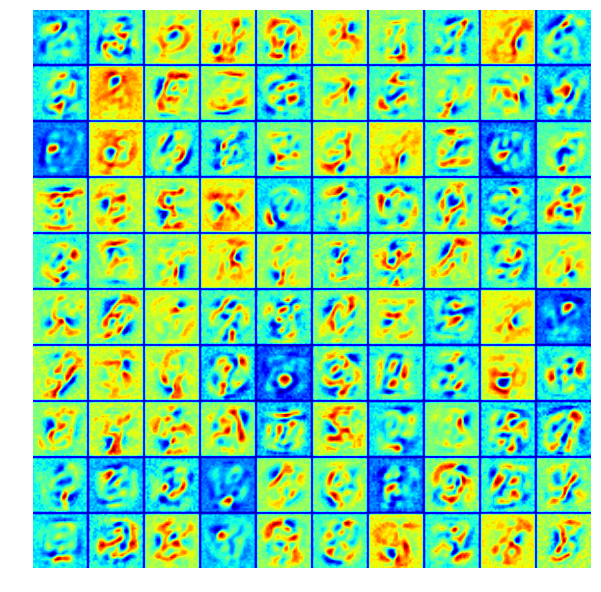

In [10]:
print('Subtask 1')
print('visualization of weights')
# visualization of weights
w1s, h1s, vr, vb1s = rbm.get_training_variables()
draw_weights(w1s, v_shape, Nh, h1_shape)


Subtask 2
visualization of reconstructions of 20 MNIST samples


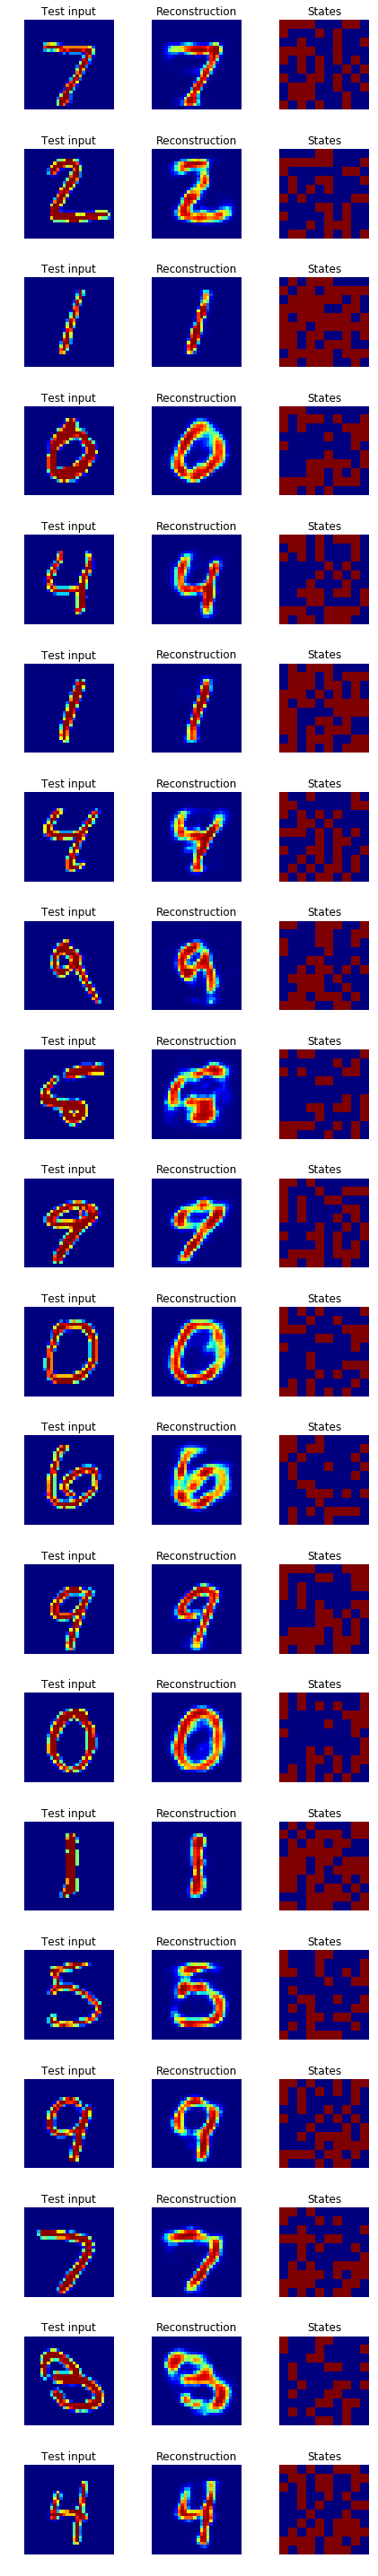

In [11]:
print('Subtask 2')
print('visualization of reconstructions of 20 MNIST samples')
# visualization of reconstructions and states
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, 20)


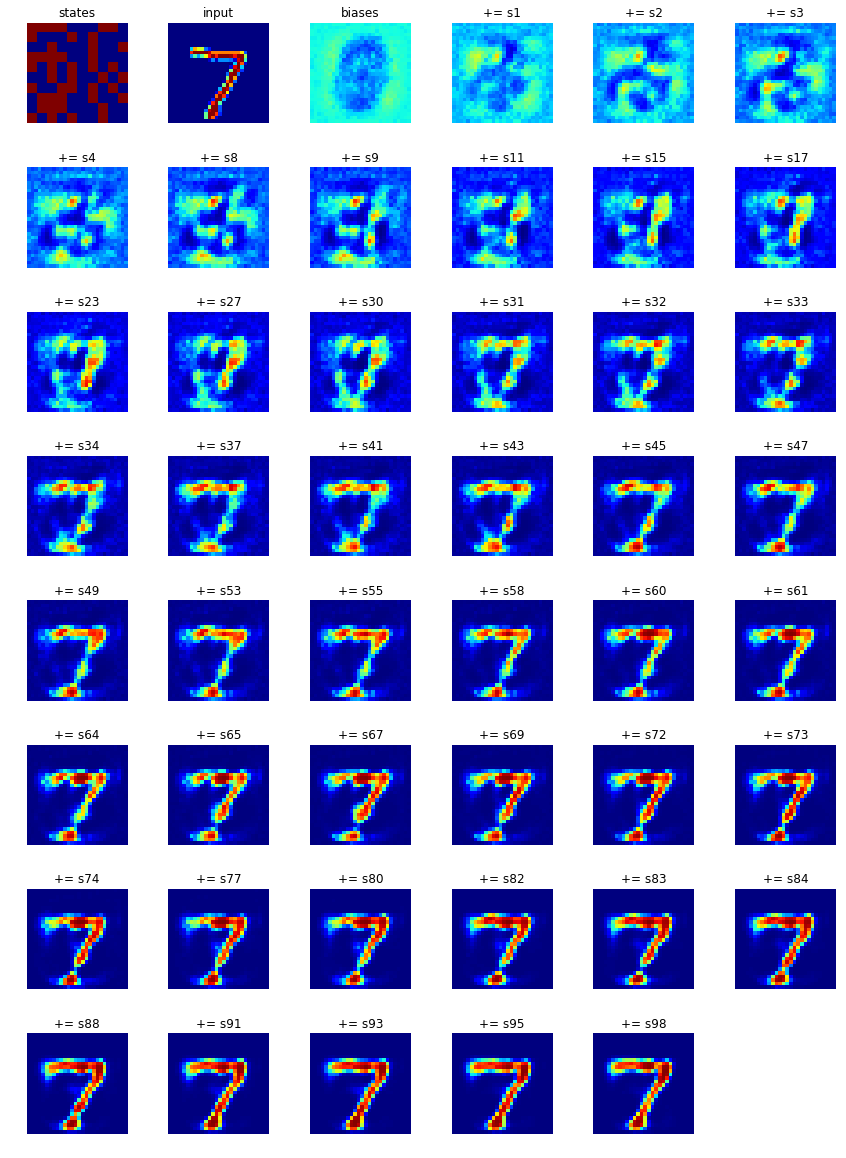

In [12]:
# visualization of a reconstructions with the gradual addition of the contributions of active hidden elements
reconstruct(0, h1s, teX, w1s, vb1s) # the first argument is the digit index in the digit matrix


In [ ]:
# The probability that the hidden state is included through Nu input samples
'''
plt.figure()
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(h1_shape)
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('likelihood of the activation of certain neurons of the hidden layer')
'''


Subtask 3
Visualization of weights sorted by frequency


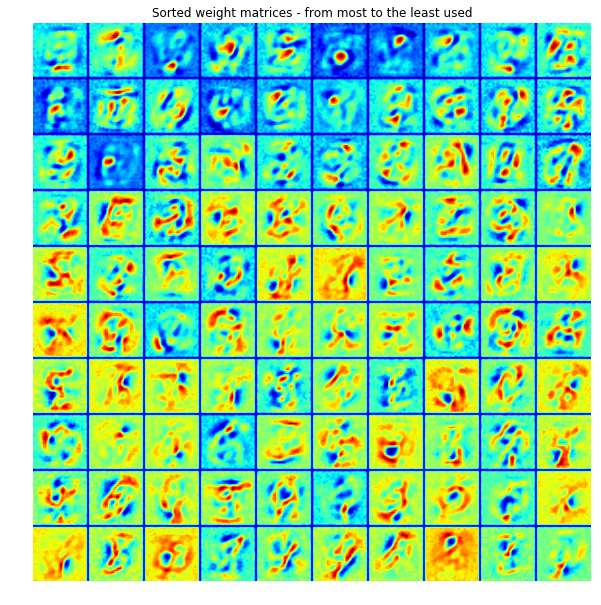

In [13]:
print('Subtask 3')
print('Visualization of weights sorted by frequency')
# Visualization of weights sorted by frequency
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(h1_shape)
tmp_ind = (-tmp).argsort(None)
draw_weights(w1s[:, tmp_ind], v_shape, Nh, h1_shape)
plt.title('Sorted weight matrices - from most to the least used')


In [15]:
print('Subtask 4')
print('Generating samples from random vectors')
# Generating samples from random vectors
r_input = np.random.rand(100, Nh)
r_input[r_input > 0.9] = 1 # percentage of active - vary freely
r_input[r_input < 1] = 0
r_input = r_input * 20 # Boosting in case a small percentage is active

s = 10
for i in range(10):
    r_input[i,:] = 0
    r_input[i,i]= s

out_1 = rbm.run_h1(r_input)
#out_1_prob, out_1, hout1 = sess1.run((v1_prob, v1, h1), feed_dict={h0: r_input})
#out_1 = sess1.run((v1), feed_dict={h0: r_input})


Subtask 4
Generating samples from random vectors


In [16]:
draw_generated(r_input, hout1, out_1_prob, v_shape, h1_shape, 10)


NameError: name 'hout1' is not defined

Subtask 5
Emulation of additional Gibbs sampling using feed_dict
0
100
200
300
400
500
600
700
800
900


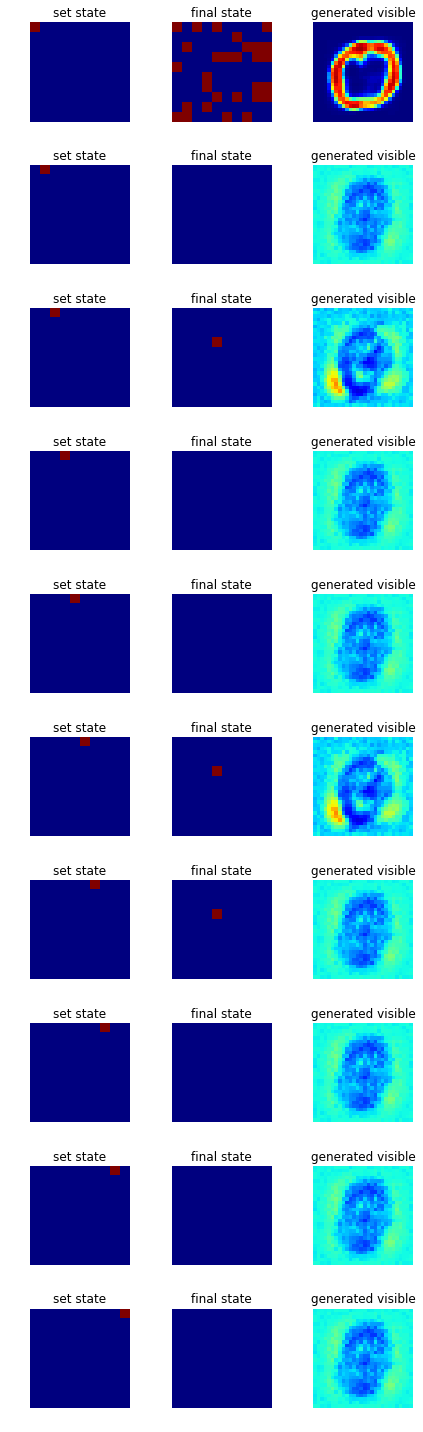

In [23]:
print('Subtask 5')
print('Emulation of additional Gibbs sampling using feed_dict')
# Emulation of additional Gibbs sampling using feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = rbm.run_X1(out_1)
    if i%100 == 0:
        print(i)

draw_generated(r_input, hout1, out_1_prob, v_shape, h1_shape, 10)

In [29]:
print('Subtask 5')
print('Increase of CD')

total_batch = 1000
alpha = 0.1

gibbs_sampling_steps = 1
print('\nCD-{}'.format(gibbs_sampling_steps))
rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)

gibbs_sampling_steps = 2
print('\nCD-{}'.format(gibbs_sampling_steps))
rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)

gibbs_sampling_steps = 3
print('\nCD-{}'.format(gibbs_sampling_steps))
rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)

gibbs_sampling_steps = 4
print('\nCD-{}'.format(gibbs_sampling_steps))
rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)

Subtask 5
Increase of CD
training, total batch: 1000
iter=0        error=0.24925108
iter=100      error=0.03756917
iter=200      error=0.03222978
iter=300      error=0.02911102
iter=400      error=0.02712662
iter=500      error=0.02544030
iter=600      error=0.02412578
iter=700      error=0.02246128
iter=800      error=0.02326048
iter=900      error=0.02366922
999 0.023619998
training, total batch: 1000
iter=0        error=0.26868892
iter=100      error=0.04631364
iter=200      error=0.04023260
iter=300      error=0.03684923
iter=400      error=0.03178987
iter=500      error=0.03042784
iter=600      error=0.03162770
iter=700      error=0.03136589
iter=800      error=0.02976248
iter=900      error=0.03176953
999 0.029479938
training, total batch: 1000
iter=0        error=0.26506570
iter=100      error=0.04728055
iter=200      error=0.04264756
iter=300      error=0.03802657
iter=400      error=0.03744865
iter=500      error=0.04078160
iter=600      error=0.03470634
iter=700      error=0.

In [33]:
print('Subtask 6')
print('different learning steps')

gibbs_sampling_steps = 1
total_batch = 1000

alpha = 0.01
print('\nalpha {}'.format(alpha))
rbm2 = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm2.train(total_batch)

alpha = 0.1
print('\nalpha {}'.format(alpha))
rbm2 = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm2.train(total_batch)

alpha = 0.2
print('\nalpha {}'.format(alpha))
rbm2 = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm2.train(total_batch)

alpha = 0.4
print('\nalpha {}'.format(alpha))
rbm2 = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)


Subtask 6
different learning steps

alpha 0.01
training, total batch: 1000
iter=0        error=0.25258714
iter=100      error=0.07252058
iter=200      error=0.06164593
iter=300      error=0.05127568
iter=400      error=0.04857426
iter=500      error=0.04301021
iter=600      error=0.04327543
iter=700      error=0.04070410
iter=800      error=0.03960549
iter=900      error=0.03751292
999 0.03645591

alpha 0.1
training, total batch: 1000
iter=0        error=0.25161138
iter=100      error=0.03698648
iter=200      error=0.03235138
iter=300      error=0.02939563
iter=400      error=0.02821645
iter=500      error=0.02554796
iter=600      error=0.02312021
iter=700      error=0.02455175
iter=800      error=0.02292524
iter=900      error=0.02359995
999 0.022914456

alpha 0.2
training, total batch: 1000
iter=0        error=0.24862359
iter=100      error=0.03512610
iter=200      error=0.02837027
iter=300      error=0.02521788
iter=400      error=0.02354721
iter=500      error=0.02312291
iter=600  

Subtask 7
Randomly initialize the hidden layer, run a few Gibbs samplings, and visualize the generated visible layer

random hidden initialization=False
training, total batch: 100
iter=0        error=0.24512063
iter=10       error=0.07766400
iter=20       error=0.07339581
iter=30       error=0.07284480
iter=40       error=0.06948970
iter=50       error=0.06809159
iter=60       error=0.07509851
iter=70       error=0.07560873
iter=80       error=0.07620061
iter=90       error=0.07315375
iter=99       error=0.07438317

random hidden initialization=True
training, total batch: 100
iter=0        error=0.24938180
iter=10       error=0.07387681
iter=20       error=0.06011180
iter=30       error=0.05589105
iter=40       error=0.04794802
iter=50       error=0.04540923
iter=60       error=0.04380046
iter=70       error=0.04248109
iter=80       error=0.03793606
iter=90       error=0.03723218
iter=99       error=0.03711720


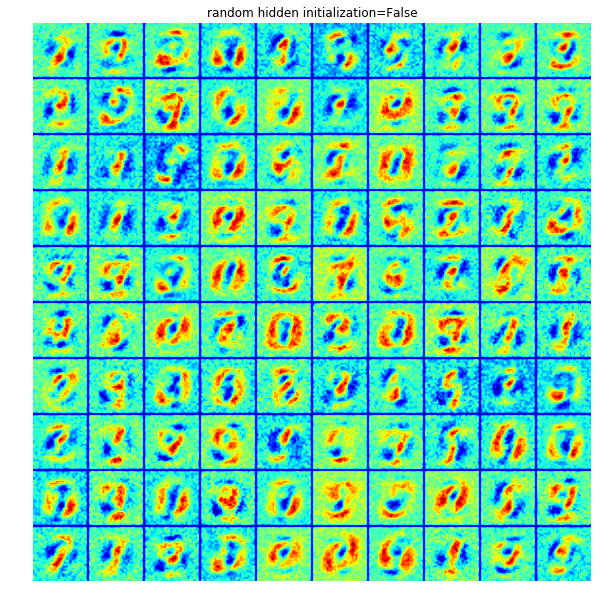

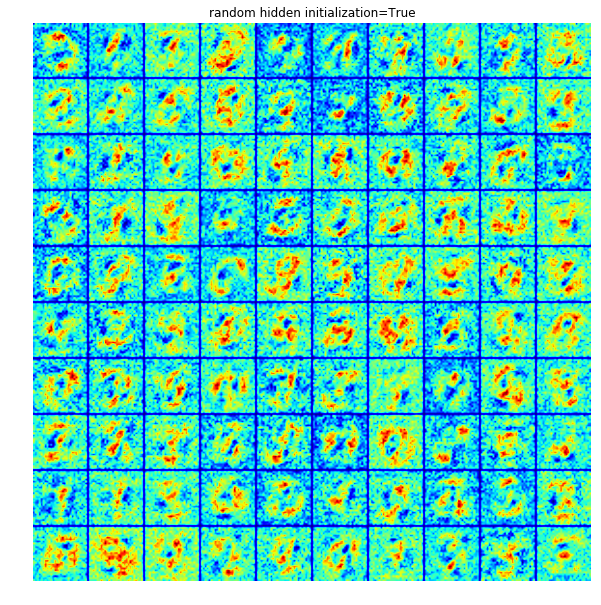

In [59]:
print('Subtask 7')
print('Randomly initialize the hidden layer, run a few Gibbs samplings, and visualize the generated visible layer')


batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples
total_batch = int(n_samples / batch_size) * epochs

Nh = 100 # The number of elements of the first hidden layer
h1_shape = (10,10)
Nv = 784 # The number of elements of the first hidden layerBroj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Number of samples for visualization of reconstruction

gibbs_sampling_steps = 1
alpha = 0.1

total_batch = 100 #int(total_batch/55)

print('\nrandom hidden initialization=False')
rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha, rnd_hidden_init=True)
rbm.train(total_batch)
w1s, h1s, vr, vb1s = rbm.get_training_variables()
draw_weights(w1s, v_shape, Nh, h1_shape, 'random hidden initialization=False')

print('\nrandom hidden initialization=True')
rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha, rnd_hidden_init=False)
rbm.train(total_batch)
w1s, h1s, vr, vb1s = rbm.get_training_variables()
draw_weights(w1s, v_shape, Nh, h1_shape, 'random hidden initialization=True')


Subtask 8
Perform above experiments with a smaller and a larger number of hidden neurons.
50 neurons in hidden layer
training, total batch: 100
iter=0        error=0.23411840
iter=10       error=0.09088065
iter=20       error=0.07880855
iter=30       error=0.06805045
iter=40       error=0.06670754
iter=50       error=0.06460593
iter=60       error=0.05793818
iter=70       error=0.05916966
iter=80       error=0.05567650
iter=90       error=0.05368284
iter=99       error=0.05482685


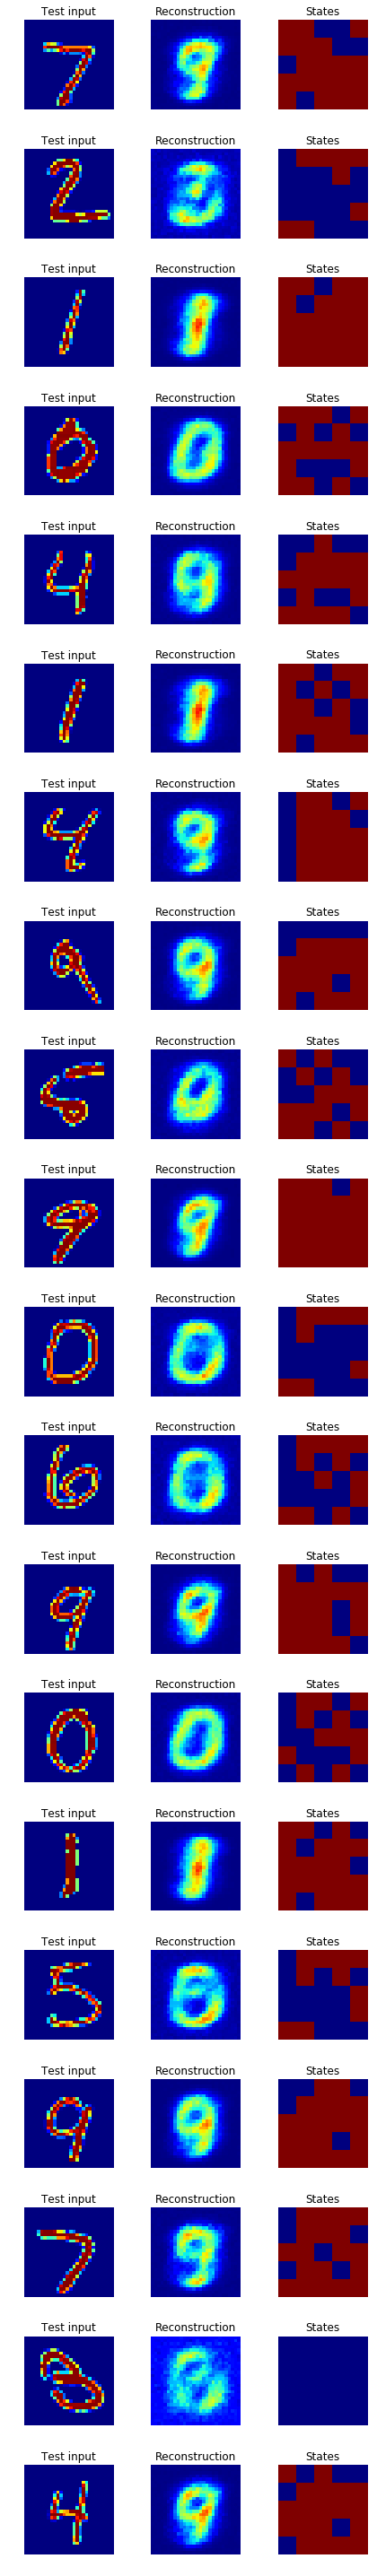

In [67]:
print('Subtask 8')
print('Perform above experiments with a smaller and a larger number of hidden neurons.')


batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples
total_batch = int(n_samples / batch_size) * epochs


print('25 (5x5) neurons in hidden layer')

Nh = 25 # The number of elements of the first hidden layer
h1_shape = (5, 5)
Nv = 784 # The number of elements of the first hidden layerBroj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Number of samples for visualization of reconstruction

gibbs_sampling_steps = 1
alpha = 0.1

total_batch = 100 #int(total_batch/55)

rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)
w1s, h1s, vr, vb1s = rbm.get_training_variables()
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, 20)


400 (20x20) neurons in hidden layer
training, total batch: 100
iter=0        error=0.27546331
iter=10       error=0.05492062
iter=20       error=0.04608415
iter=30       error=0.04101102
iter=40       error=0.03779574
iter=50       error=0.03442523
iter=60       error=0.03361670
iter=70       error=0.03097037
iter=80       error=0.02920467
iter=90       error=0.02955264
iter=99       error=0.02832661


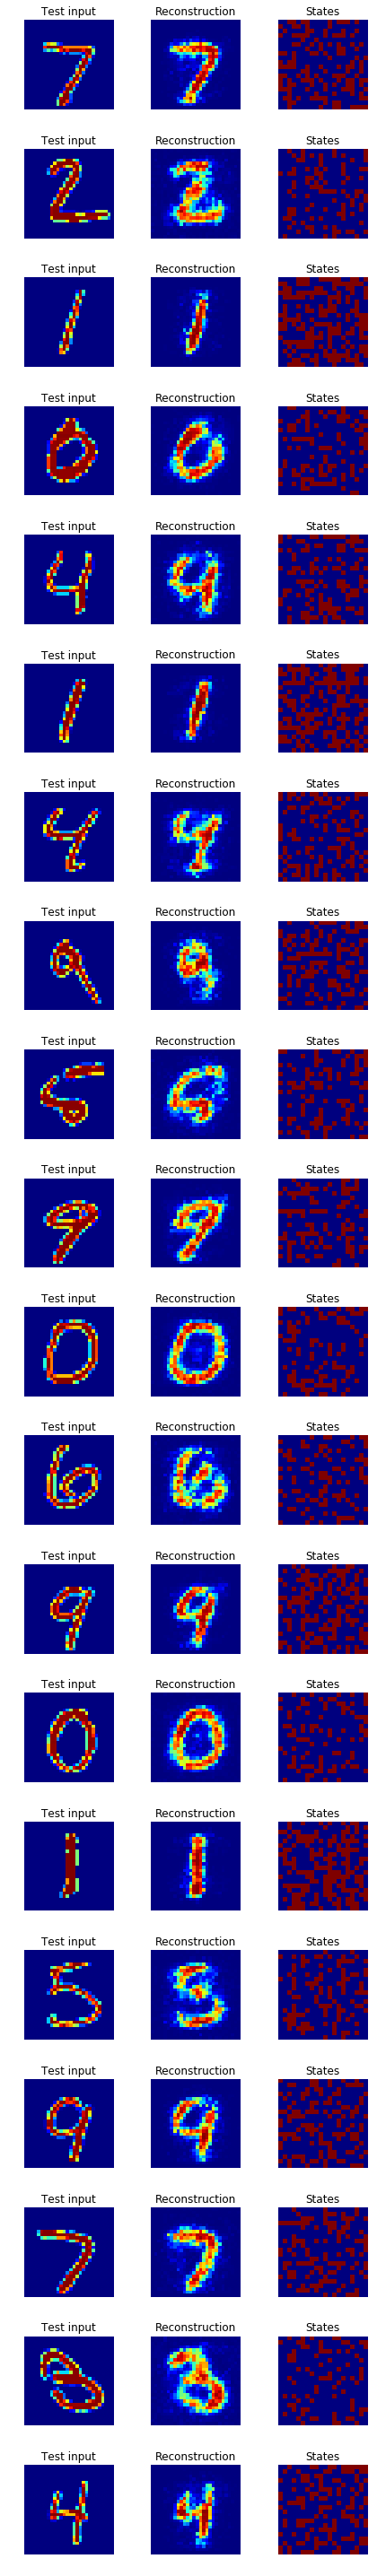

In [69]:

print('400 (20x20) neurons in hidden layer')

Nh = 400 # The number of elements of the first hidden layer
h1_shape = (20, 20)
Nv = 784 # The number of elements of the first hidden layerBroj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Number of samples for visualization of reconstruction

gibbs_sampling_steps = 1
alpha = 0.1

total_batch = 100 #int(total_batch/55)

rbm = Task1(Nh, h1_shape, Nv, v_shape, Nu, gibbs_sampling_steps, alpha)
rbm.train(total_batch)
w1s, h1s, vr, vb1s = rbm.get_training_variables()
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, 20)